# Test Time Augmention

After training an ensemble or any other bayesian neural network on a dataset, we create an augmented version of the dataset to test on. This augmented dataset allows us probe our model's confidence in predictions. In this example we are working with the MNIST dataset, and apply rotations as well as noise at test time. By plotting the change in logits and probabilities over a range of rotations we can obeserve our model's uncertainty when viewing new data that is not similar to the training set.

## Rotation Augmentation

##### Dataset

In [1]:
import os
from torchvision import transforms
from experiments.nns.bdl import SelectMNISTDataset

# Define the path to the directory containing MNIST
base_path = "/usr/data1/vision/data/"
mnist_directory = os.path.abspath(base_path)

# Define a transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST training dataset
train_dataset = SelectMNISTDataset(
    root=mnist_directory,
    train=True,
    numbers=list(range(10)),  # Simplified way to include numbers 0-9
    num_entries_per_digit=10,
    transform=transform
)


## Creating rotated dataset

In [2]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.nns.bdl import CustomMNISTDataset

# Define which digits to include
selected_numbers = [1]

# Define rotation angles
rotation_angles = [i * 5.5 for i in range(12)]

# Transformation to normalize the data
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def create_dataset_with_rotation(degrees, mnist_path, numbers, train=False):
    """Creates a dataset and corresponding DataLoader for rotated MNIST images."""
    rotate_transform = transforms.Compose([
        transforms.RandomRotation(degrees=(degrees, degrees), fill=(0,)),
        base_transform
    ])
    dataset = CustomMNISTDataset(root=mnist_path, numbers=numbers, train=train, transform=rotate_transform)
    loader = DataLoader(dataset, batch_size=512, shuffle=False)
    return dataset, loader

# Generate datasets and loaders for each rotation angle
datasets_and_loaders = [create_dataset_with_rotation(angle, mnist_directory, selected_numbers) for angle in rotation_angles]

# Optionally unpack datasets and loaders into separate lists (if needed)
rotated_datasets, rotated_loaders = zip(*datasets_and_loaders)

# Non-rotated test dataset and loader
test_dataset, test_loader = create_dataset_with_rotation(0, mnist_directory, selected_numbers)  # Zero degrees rotation for non-rotated dataset


## Training

### Deep Ensemble

In [3]:
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from experiments.nns.lenet.lenet import LeNet
import push.bayes.ensemble as ensemble_module

# Configuration for training
batch_size = 512
epochs = 500
n_ensembles = 8
learning_rate = 0.01

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train a deep ensemble of LeNet models
ensemble = ensemble_module.train_deep_ensemble(
    dataloader=train_loader,
    loss_fn=CrossEntropyLoss(),
    epochs=epochs,
    nn=LeNet,
    num_devices=2,
    num_ensembles=n_ensembles,
    cache_size=25
)


100%|██████████| 500/500 [01:13<00:00,  6.85it/s, loss=tensor(0.0828)]


### MultiSWAG

In [4]:
import push.bayes.swag as swag_module

# SWAG Training Configuration
pretrain_epochs = 250
swag_epochs = 250
n_models = n_ensembles  # Assuming 'n_ensembles' should be used here

# Train SWAG model
swag = swag_module.train_mswag(
    dataloader=train_loader,
    loss_fn=CrossEntropyLoss(),
    pretrain_epochs=pretrain_epochs,
    swag_epochs=swag_epochs,
    nn=LeNet,
    num_devices=2,
    num_models=n_models,
    lr=learning_rate
)

100%|██████████| 250/250 [00:35<00:00,  7.05it/s, loss=tensor(0.0034)]


### SVGD

In [5]:
import push.bayes.stein_vgd as stein_vgd_module

# Configuration for training
batch_size = 512
epochs = 500
learning_rate = 0.3  
n_particles = 8
lengthscale = 0.5
num_devices = 2

# Train SVGD model
svgd = stein_vgd_module.train_svgd(
    dataloader=train_loader,
    loss_fn=CrossEntropyLoss(),
    epochs=epochs,
    num_particles=n_particles,
    nn=LeNet,
    lengthscale=lengthscale,
    lr=learning_rate,
    num_devices=num_devices
)

100%|██████████| 500/500 [09:59<00:00,  1.20s/it, loss=tensor(0.0049)]


## Inference

In [6]:
def gather_outputs(model, loaders):
    return [model.posterior_pred(loader, f_reg=False, mode=["mode", "logits", "prob"]) for loader in loaders]

rotated_outputs = {"ensemble" : gather_outputs(ensemble, rotated_loaders), "swag" : gather_outputs(swag, rotated_loaders), "svgd" : gather_outputs(svgd, rotated_loaders)}

def get_mode(output, mode):
    """Retrieve a specific mode from model outputs."""
    return output[mode]


## Helper functions for output and plots

## Gaussian Noise

In [7]:
import os
from torch.utils.data import DataLoader
from torchvision import transforms
from experiments.nns.bdl import CustomMNISTDataset, AddGaussianNoise, AddImpulseNoise, AddDefocusBlur

# Configuration
selected_numbers = [1]
variances = [0.1, 0.2, 0.4, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
probs = [0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24, 20.48, 40.96]
radii = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Define the path to the MNIST directory

def create_noisy_loader(numbers, noise_transform):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        noise_transform
    ])
    dataset = SelectMNISTDataset(root=mnist_directory, numbers=selected_numbers, num_entries_per_digit=1, train=False, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=False)

def create_datasets_and_loaders(numbers, noise_list, noise_creator):
    datasets, loaders = [], []
    for noise_param in noise_list:
        noise = noise_creator(noise_param)
        loader = create_noisy_loader(numbers, noise)
        datasets.append(loader.dataset)
        loaders.append(loader)
    return datasets, loaders

# Creating noisy datasets and loaders
gaussian_datasets, gaussian_loaders = create_datasets_and_loaders(selected_numbers, variances, lambda v: AddGaussianNoise(0., v))
impulse_datasets, impulse_loaders = create_datasets_and_loaders(selected_numbers, probs, AddImpulseNoise)
defocus_datasets, defocus_loaders = create_datasets_and_loaders(selected_numbers, radii, AddDefocusBlur)


In [8]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to gather outputs for a given noise type
def gather_outputs(models, loaders):
    outputs = {model: [] for model in models}
    for loader in loaders:
        for model in models:
            outputs[model].append(model.posterior_pred(loader, f_reg=False, mode=["mode", "logits", "prob"]))
    return outputs

# Define the models
models = [ensemble, swag, svgd]

# Gather outputs for each type of noise
gaussian_outputs = gather_outputs(models, gaussian_loaders)
impulse_outputs = gather_outputs(models, impulse_loaders)
defocus_outputs = gather_outputs(models, defocus_loaders)

# Utility function to extract specific mode from outputs
def get_mode(output, mode):
    return output[mode]


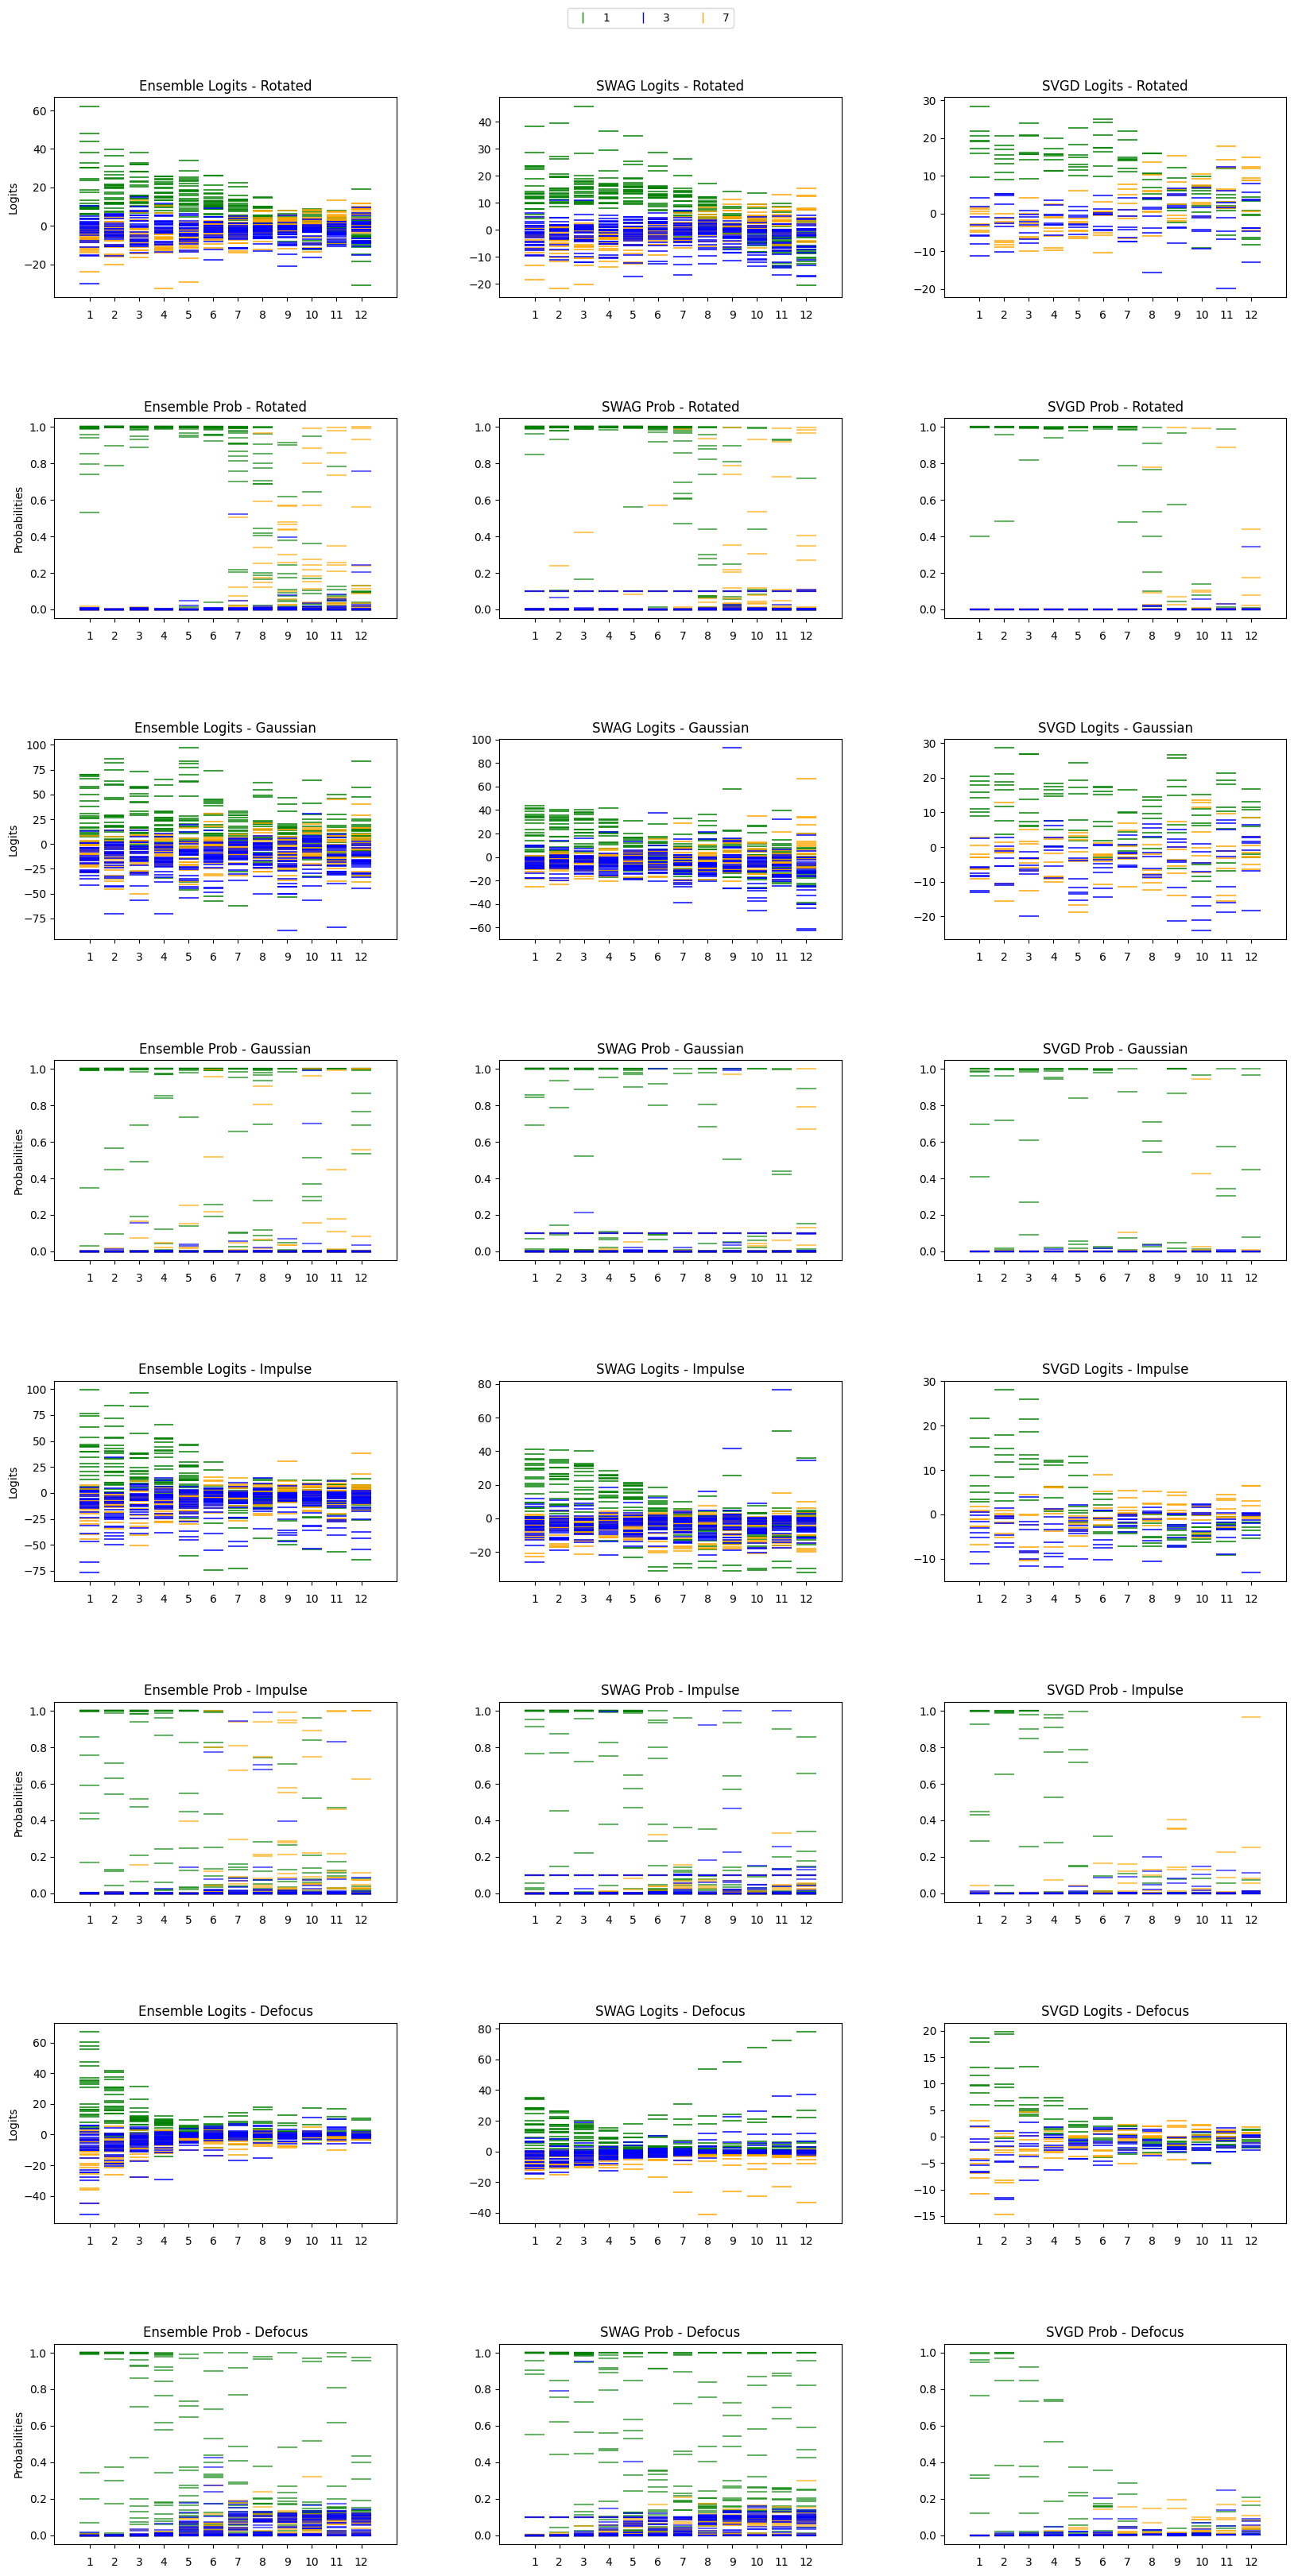

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_imgs(loaders, idx_image_to_display=0):
    imgs = []
    for loader in loaders:
        for images, _ in loader:
            imgs.append(images[idx_image_to_display])
            break
    return imgs

def offset_image(coord, ax, low_img, low_index, zoom, img):
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, low_img), xybox=(0.0, low_index), frameon=False, boxcoords="offset points")
    ax.add_artist(ab)

def align_images_on_x_axis(ax):
    # Find the transformed position of the lower limit of the y-axis
    inv = ax.transData.inverted()
    # Set to a fixed offset from the bottom of the axes
    _, y_data_coord = inv.transform((0, ax.figure.bbox.ymin))
    y_offset = y_data_coord - 0.3  # Adjust this offset as needed

    # Update the y-coordinates for images in this axis
    for ab in [child for child in ax.get_children() if isinstance(child, AnnotationBbox)]:
        ab.xybox = (0.0, y_offset)

def plot_data(ax, outputs, title, loaders, idx_image_to_display=0, stat_type="logits"):
    color_map = {"logits": ["green", "orange", "blue"], "prob": ["green", "orange", "blue"]}
    alpha_map = {"logits": 0.75, "prob": 0.6}
    index = np.arange(len(outputs))
    imgs = get_imgs(loaders, idx_image_to_display)
    zoom = 0.4

    for i, output in enumerate(outputs):
        data = get_mode(output, stat_type)[:, :, [1, 3, 7]][idx_image_to_display]
        for j, val in enumerate(data.T):
            ax.eventplot(val, orientation="vertical", lineoffsets=i, linelengths=0.8, colors=color_map[stat_type][j], alpha=alpha_map[stat_type])

    setup_axis(ax, index, title, stat_type)
    # annotate_images(ax, index, imgs, zoom)
    align_images_on_x_axis(ax)

def setup_axis(ax, index, title, stat_type):
    ax.set_xticks(index)
    ax.set_xticklabels(index + 1)
    ax.tick_params(axis="x", which="major", pad=8)
    ax.set_ylabel("Logits" if stat_type == "logits" else "Probabilities")
    ax.set_title(title, fontsize=12)

def annotate_images(ax, index, imgs, zoom):
    low_img, _ = ax.get_ylim()
    for i, img in enumerate(imgs):
        offset_image(i, ax, low_img, low_img - 5, zoom, img)

def get_mode(output, mode):
    return output[mode]

# Define the datasets and loaders
# Ensure outputs and loaders are defined: ensemble_outputs, swag_outputs, svgd_outputs, etc.

method_names = ['Ensemble', 'SWAG', 'SVGD']
noise_types = ['Rotated', 'Gaussian', 'Impulse', 'Defocus']
outputs_dict = {
    'Rotated': (rotated_outputs["ensemble"], rotated_outputs["swag"], rotated_outputs["svgd"], rotated_loaders),
    'Gaussian': (gaussian_outputs[ensemble], gaussian_outputs[swag], gaussian_outputs[svgd], gaussian_loaders),
    'Impulse': (impulse_outputs[ensemble], impulse_outputs[swag], impulse_outputs[svgd], impulse_loaders),
    'Defocus': (defocus_outputs[ensemble], defocus_outputs[swag], defocus_outputs[svgd], defocus_loaders)
}


# Plotting code
fig_width, fig_height = 20, 40  # Increase figure height to provide more space
fig, axes = plt.subplots(nrows=2*len(noise_types), ncols=len(method_names), figsize=(fig_width, fig_height))

for row_idx, noise in enumerate(noise_types):
    for col_idx, method in enumerate(method_names):
        outputs, loaders = outputs_dict[noise][col_idx], outputs_dict[noise][-1]
        # Plot logits
        ax_logits = axes[2*row_idx, col_idx]
        plot_data(ax_logits, outputs, f"{method} Logits - {noise}", loaders, stat_type='logits')
        # Plot probabilities
        ax_prob = axes[2*row_idx + 1, col_idx]
        plot_data(ax_prob, outputs, f"{method} Prob - {noise}", loaders, stat_type='prob')
        # Hide y-labels for all but the first column
        if col_idx > 0:
            ax_logits.set_ylabel('')
            ax_prob.set_ylabel('')

# Adjust subplot parameters to fit everything
plt.subplots_adjust(hspace=0.6, wspace=0.3)

import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='green', marker='|', linestyle='None', markersize=10, label='1'),
    mlines.Line2D([], [], color='blue', marker='|', linestyle='None', markersize=10, label='3'),
    mlines.Line2D([], [], color='orange', marker='|', linestyle='None', markersize=10, label='7'),
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.9), ncol=3)

# Save the plot to a file to prevent display issues in Jupyter Notebook
# plt.savefig('/augmentation_plot.png', dpi=300, bbox_inches='tight')

plt.show()




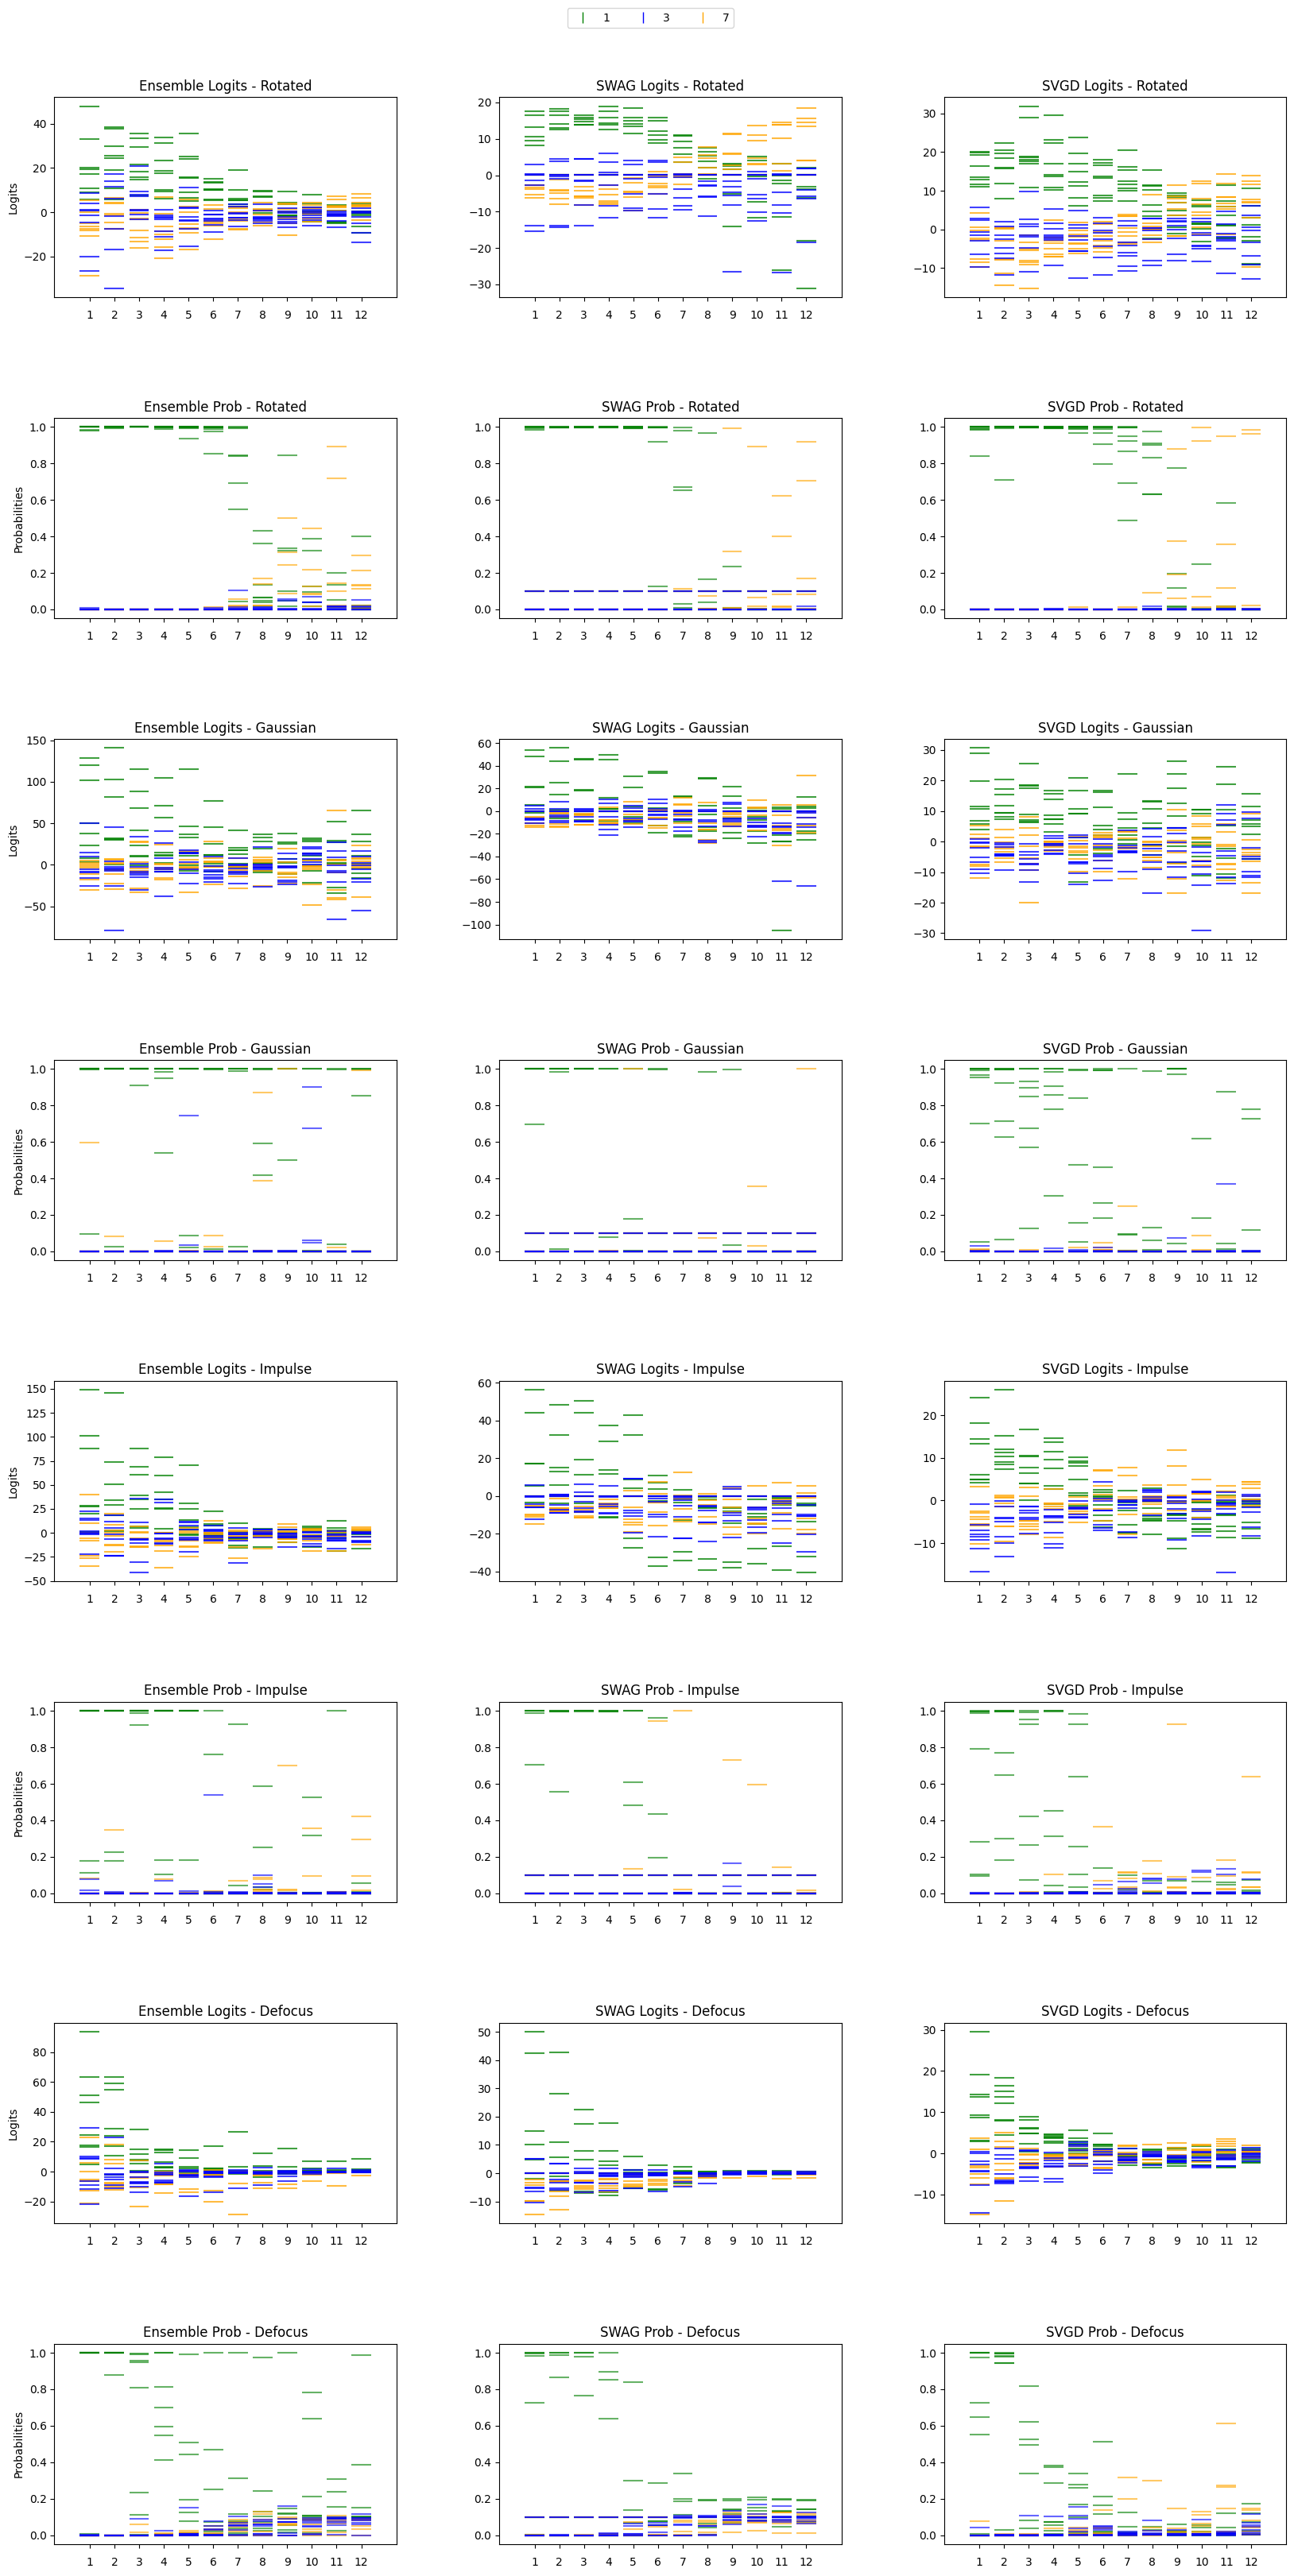

: 

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_imgs(loaders, idx_image_to_display=0):
    imgs = []
    for loader in loaders:
        for images, _ in loader:
            imgs.append(images[idx_image_to_display])
            break
    return imgs

def offset_image(coord, ax, low_img, low_index, zoom, img):
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, low_img), xybox=(0.0, low_index), frameon=False, boxcoords="offset points")
    ax.add_artist(ab)

def align_images_on_x_axis(ax):
    # Find the transformed position of the lower limit of the y-axis
    inv = ax.transData.inverted()
    # Set to a fixed offset from the bottom of the axes
    _, y_data_coord = inv.transform((0, ax.figure.bbox.ymin))
    y_offset = y_data_coord - 0.3  # Adjust this offset as needed

    # Update the y-coordinates for images in this axis
    for ab in [child for child in ax.get_children() if isinstance(child, AnnotationBbox)]:
        ab.xybox = (0.0, y_offset)

def plot_data(ax, outputs, title, loaders, idx_image_to_display=0, stat_type="logits"):
    color_map = {"logits": ["green", "orange", "blue"], "prob": ["green", "orange", "blue"]}
    alpha_map = {"logits": 0.75, "prob": 0.6}
    index = np.arange(len(outputs))
    imgs = get_imgs(loaders, idx_image_to_display)
    zoom = 0.4

    for i, output in enumerate(outputs):
        data = get_mode(output, stat_type)[:, :, [1, 3, 7]][idx_image_to_display]
        for j, val in enumerate(data.T):
            ax.eventplot(val, orientation="vertical", lineoffsets=i, linelengths=0.8, colors=color_map[stat_type][j], alpha=alpha_map[stat_type])

    setup_axis(ax, index, title, stat_type)
    # annotate_images(ax, index, imgs, zoom)
    align_images_on_x_axis(ax)

def setup_axis(ax, index, title, stat_type):
    ax.set_xticks(index)
    ax.set_xticklabels(index + 1)
    ax.tick_params(axis="x", which="major", pad=8)
    ax.set_ylabel("Logits" if stat_type == "logits" else "Probabilities")
    ax.set_title(title, fontsize=12)

def annotate_images(ax, index, imgs, zoom):
    low_img, _ = ax.get_ylim()
    for i, img in enumerate(imgs):
        offset_image(i, ax, low_img, low_img - 5, zoom, img)

def get_mode(output, mode):
    return output[mode]

# Define the datasets and loaders
# Ensure outputs and loaders are defined: ensemble_outputs, swag_outputs, svgd_outputs, etc.

method_names = ['Ensemble', 'SWAG', 'SVGD']
noise_types = ['Rotated', 'Gaussian', 'Impulse', 'Defocus']
outputs_dict = {
    'Rotated': (rotated_outputs["ensemble"], rotated_outputs["swag"], rotated_outputs["svgd"], rotated_loaders),
    'Gaussian': (gaussian_outputs[ensemble], gaussian_outputs[swag], gaussian_outputs[svgd], gaussian_loaders),
    'Impulse': (impulse_outputs[ensemble], impulse_outputs[swag], impulse_outputs[svgd], impulse_loaders),
    'Defocus': (defocus_outputs[ensemble], defocus_outputs[swag], defocus_outputs[svgd], defocus_loaders)
}


# Plotting code
fig_width, fig_height = 20, 40  # Increase figure height to provide more space
fig, axes = plt.subplots(nrows=2*len(noise_types), ncols=len(method_names), figsize=(fig_width, fig_height))

for row_idx, noise in enumerate(noise_types):
    for col_idx, method in enumerate(method_names):
        outputs, loaders = outputs_dict[noise][col_idx], outputs_dict[noise][-1]
        # Plot logits
        ax_logits = axes[2*row_idx, col_idx]
        plot_data(ax_logits, outputs, f"{method} Logits - {noise}", loaders, stat_type='logits')
        # Plot probabilities
        ax_prob = axes[2*row_idx + 1, col_idx]
        plot_data(ax_prob, outputs, f"{method} Prob - {noise}", loaders, stat_type='prob')
        # Hide y-labels for all but the first column
        if col_idx > 0:
            ax_logits.set_ylabel('')
            ax_prob.set_ylabel('')

# Adjust subplot parameters to fit everything
plt.subplots_adjust(hspace=0.6, wspace=0.3)

import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='green', marker='|', linestyle='None', markersize=10, label='1'),
    mlines.Line2D([], [], color='blue', marker='|', linestyle='None', markersize=10, label='3'),
    mlines.Line2D([], [], color='orange', marker='|', linestyle='None', markersize=10, label='7'),
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.9), ncol=3)

# Save the plot to a file to prevent display issues in Jupyter Notebook
# plt.savefig('/augmentation_plot.png', dpi=300, bbox_inches='tight')

plt.show()




[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.